<center>
<img src="warwick-logo.png">
<h1>Interoperability between scientific computing codes with Python</h1>
<h3>James Kermode</h3>
Warwick Centre for Predictive Modelling / School of Engineering<br>
University of Warwick
<br>
<br>
<img src="WCPM_logo_text.png" width="50%">

</center>

<br>
<br>
<br>
<br>

In [208]:
import numpy as np
import matplotlib.pyplot as plt

#Customize default plotting style
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [209]:
plt.rcParams["figure.figsize"] = (10, 8)

# Introduction

- Interfacing codes allows existing tools to be combined
- Produce something that is more than the sum of the constituent parts 
- General feature of modern scientific computing: many well-documented libraries available
- Python has emerged as the *de facto* standard “glue” language
- Codes that have a Python interface can be combined in complex ways

## Motivation

- My examples are from atomistic materials modelling and electronic structure, but approach is general
- All the activities I'm interested in require *robust*, *automated* coupling of two or more codes
- For example, current projects include:
    - developing and applying multiscale methods
    - generating interatomic potentials
    - uncertainty quantification

<img src="multiscale.png" width="70%">

# Python scripting for interoperability

- [numpy](http://www.numpy.org/)/[scipy](http://scipy.org/) ecosystem
- [matplotlib](http://matplotlib.org/) plotting and interactive graphics
- [jupyter](https://jupyter.org/)/IPython notebooks encourage reproducible research
- [anaconda](https://jupyter.org/) distribution and package management system
   
<center><img src="scipy-stack.png" width="70%"></center>

http://www.scipy.org

# Atomic Simulation Environment (ASE)

- Within atomistic modelling, emerging standard for scripting interfaces is ASE
- Wide range of calculators, flexible (but not too flexible) data model for Atoms objects
- Can use many codes as drop-in replacements:

<center><img src="ase-calculators.png" width="60%"></center>


https://wiki.fysik.dtu.dk/ase/

# Atomic Simulation Environment (ASE)

- ASE mostly uses file-based interfaces: input generators and output parsers
- Collection of parsers aids validation and verification - cf. DFT $\Delta$-code project
- Coupling $N$ codes requires maintaining $N$ parsers/interfaces, rather than $N^2$ converters
- High-level functionality can be coded generically, or imported from other packages (e.g. `spglib`, `phonopy`) using minimal ASE-compatible API

# File-based interfaces vs. Native interfaces

- File-based interfaces (like those mostly used in ASE) to electronic structure codes can be slow and/or incomplete and parsers are hard to keep up to date and robust
- Standardised output (e.g. chemical markup language, XML, JSON) part of solution
- So are robust parsers - [NoMaD Centre of Excellence](http://nomad-coe.eu/) has produced parsers for top ~40 electronic structure and atomistic codes
- **Alternative:** native interfaces provide a much deeper wrapping, exposing full public API of code to script writers (e.g. GPAW, LAMMPSlib)
- **Future proofing:** anything accessible from Python works with other high-level languages (e.g. Julia)

   
# `f90wrap` adds derived type support to `f2py`

- Writing deep Python interfaces 'by hand' is possible but tedious
- There are good automatic interface generators for C++ codes (e.g. SWIG or Boost.Python), but none support modern Fortran
    - There's still lots of high-quality Fortran code around...
    - [f2py](https://sysbio.ioc.ee/projects/f2py2e/) scans Fortran 77/90/95 codes, generates Python interfaces for individual routines
    - No support for modern Fortran features: derived types, overloaded interfaces
- My `f90wrap` package addresses this by generating an additional layer of wrappers, adding support for derived types, module data, efficient array access, Python 2.6+ and 3.x

https://github.com/jameskermode/f90wrap    

# Example: wrapping  the `bader` code

- Widely used code for post-processing charge densities to construct Bader volumes
- Python interface would allow code to be used in workflows without I/O etc.
- Downloaded [source](http://theory.cm.utexas.edu/henkelman/code/bader/), used `f90wrap` to *automatically* generate a deep Python interface with very little manual work

Generation and compilation of wrappers:

    f90wrap -v -k kind_map -I init.py -m bader \
         kind_mod.f90 matrix_mod.f90 \
         ions_mod.f90 options_mod.f90 charge_mod.f90 \
         chgcar_mod.f90 cube_mod.f90 io_mod.f90 \
         bader_mod.f90 voronoi_mod.f90 multipole_mod.f90

    f2py-f90wrap -c -m _bader f90wrap_*.f90 -L. -lbader

To install it yourself, run the commands below, taking care to adjust `PY_INSTALL_DIR` according to your local setup:

    git clone https://gitlab.com/jameskermode/bader
    cd bader
    export PY_INSTALL_DIR=$HOME/.pyenv/versions/3.6.6/lib/python3.6/site-packages
    make -f makefile.osx_gfortran python

# Example: wrapping the `bader` code (contd.)

Restart a `gpaw` DFT calculation (or run if necessary) and retrieve the density:

In [210]:
import os
from ase.build import bulk
from gpaw import GPAW, restart

if not os.path.exists('si-vac.gpw'):
    si = bulk('Si', cubic=True)
    #del si[0] # create a vacancy
    gpaw = GPAW(h=0.15) 
    si.set_calculator(gpaw)
    si.get_potential_energy()
    gpaw.write('si-vac.gpw')

si, gpaw = restart('si-vac.gpw')
rho = gpaw.get_pseudo_density()

Hamiltonian:
  XC and Coulomb potentials evaluated on a 72*72*72 grid
  Using the LDA Exchange-Correlation functional
  Interpolation: tri-quintic (5. degree polynomial)
  Poisson solver: FastPoissonSolver using
    6*3+1=19 point O(h^6) finite-difference Laplacian stencil;
    FFT axes: [0, 1, 2];
    FST axes: [].
 

Memory estimate:
  Process memory now: 405.39 MiB
  Calculator: 99.37 MiB
    Density: 64.34 MiB
      Arrays: 9.25 MiB
      Localized functions: 51.52 MiB
      Mixer: 3.56 MiB
    Hamiltonian: 9.88 MiB
      Arrays: 6.05 MiB
      XC: 0.00 MiB
      Poisson: 0.00 MiB
      vbar: 3.83 MiB
    Wavefunctions: 25.15 MiB
      Arrays psit_nG: 8.54 MiB
      Eigensolver: 10.37 MiB
      Projections: 0.02 MiB
      Projectors: 6.22 MiB

Total number of cores used: 1

Number of atoms: 8
Number of atomic orbitals: 32
Number of bands in calculation: 24
Bands to converge: occupied states only
Number of valence electrons: 32

... initialized

Timing:           incl.     excl.
---

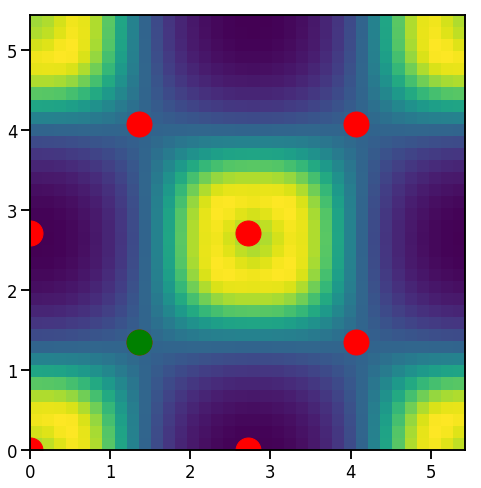

In [211]:
atom = 3
plt.plot(si.positions[:, 0], si.positions[:, 1], 'r.', ms=50)
plt.plot(si.positions[atom, 0], si.positions[5, 1], 'g.', ms=50)
plt.imshow(rho[:,:,0], extent=[0, si.cell[0,0], 0, si.cell[1,1]]);

In [212]:
import bader
from caspytep.util import capture_stdout

with capture_stdout():
    bdr = bader.bader(si, rho)

print('ionchg:', bdr.ionchg)


  CALCULATING BADER CHARGE DISTRIBUTION
                 0  10  25  50  75  100
  PERCENT DONE:  ********************** 

  REFINING AUTOMATICALLY
  ITERATION: 2
  CHECKED POINTS:          0
  REASSIGNED POINTS:       0

  RUN TIME:       0.09 SECONDS

  CALCULATING MINIMUM DISTANCES TO ATOMS
                 0  10  25  50  75  100
  PERCENT DONE:  **********************

  RUN TIME:    0.01 SECONDS
ionchg: [4.40091789 4.32550003 4.33740163 4.34498556 4.31972604 4.33803196
 4.31717912 4.33598514]


In [214]:
import nglview

In [215]:
## TAB-complete to introspect inside `bdr` Fortran type
#bdr.

In [217]:
# collect Bader volumes associated with atom #5
atom = 3
rho3 = np.zeros_like(rho)
for v in (bdr.nnion == atom+1).nonzero()[0]:
    rho3[bdr.volnum == v+1] = rho[bdr.volnum == v+1]    

In [218]:
# write a CUBE file to allow visualisation of density (FIXME: can this be avoided?)
from ase.io.cube import write_cube

with open('rho3.cube', 'w') as f:
    write_cube(f, si, rho3)

In [219]:
v = nglview.show_ase(si, gui=True)
v.add_representation('unitcell')
v.add_component('rho3.cube')
v.component_1.update_surface()
v

NGLWidget()

# Wrapping Castep with f90wrap - CasPyTep

- `f90wrap` can now wrap large codes like Castep to provide deep access to internal data 
- Summer project in 2014 by Greg Corbett at STFC built proof-of-principle Castep/Python interface. Results described in [RAL technical report](https://epubs.stfc.ac.uk/work/18048381)
- Warwick MSc student Sebastian Potthoff wrote his dissertation on `CasPyTep` in 2016, adding MPI support and optimising performance of Nudged Elastic Band algorithm, coded in Python
- Since then I've extended a bit further - e.g. adding Python 3.x support

# CasPyTep Requirements

 - Castep source code - tested with latest development version (plus patch  for Py 3.x; pull request submitted!)
 - Supported Fortran compiler (tested with `gfortran` and `ifort`)
 - [Python](http://www.python.org) Python 3.6+
 - [Numpy](http://www.numpy.org): `pip install numpy`
 - [f90wrap](https://github.com/jameskermode/f90wrap) package: `pip install f90wrap`
 - [Atomic Simulation Enviroment](https://wiki.fysik.dtu.dk/ase/) (ASE): `pip install ase`


# Compiling CasPyTep

In principle:

    cd castep
    make
    make python
    export PY_INSTALL_DIR=/usr/local/python3.7/site-packages # or somewhere else
    make python-install

In practice it can be a bit fiddly, and right now you need access to [my development fork](https://bitbucket.org/jameskermode/castep) of CASTEP (pull request pending) -- please ask me if you would like to try this out.

# CasPyTep Docker image

<img src="https://d1q6f0aelx0por.cloudfront.net/icons/docker-edition-windows6.png" width="10%" align="left" style="padding:10px;">
   
Easiest to use CasPyTep via a pre-build [Docker](https://www.docker.com) image that extends our [libatomsquip](https://hub.docker.com/u/libatomsquip/) image, and comes fully loaded with Python dependencies plus nice-to-have extras (e.g. numpy, ASE, QUIP, matplotlib, jupyter, LAMMPS, GPAW, Julia...).

<br>

**Starting the Docker image:**

    gzcat caspytep.tar.gz | docker load
    docker run -v ~:/root/host -p 8899:8899 caspytep

- `-p` required to redirect port used by Juypyter notebook webserver
- `-v` optional argument mounts your home directory inside the container
    
Then point your web brower at http://localhost:8899

# CasPyTep Current Features

- Set of source files currently wrapped is as follows, can be easily expanded:

        Utility:     constants.F90 algor.F90 comms.serial.F90
                     io.F90 trace.F90 license.F90 buildinfo.f90
        Fundamental: parameters.F90 cell.F90 basis.F90 
                     ion.F90 density.F90 wave.F90
        Functional:  model.F90 electronic.F90 firstd.f90 xc.f90
        
- Already far too much to wrap by hand: 
   - 35 kLOC Fortran and 55 kLOC Python auto-generated 
   - 23 derived types 
   - ~2600 subroutines/functions

# What is wrapped?

- Dynamic introspection of data and objects:
    - Module-level variables: `current_cell`, etc (*NB:* must have `target` attribute)
    - Fortran derived types exposed as Python classes (e.g `unit_cell`, `model_state`), including all elements, arrays, etc. within them
    - Arrays (including arrays of derived types) - no copying necessary to access data in numerical arrays e.g. `current_cell%ionic_positions` exposed directly in Python
- Documentation strings are extracted from source code
- `io_abort()` raises `RuntimeError` exception
- Plus, there's a minimal ASE-compatible high level calculator `CasPyTep(atoms)`

# Taking `caspytep` for a test drive

In [30]:
import numpy as np
import caspytep

In [ ]:
## uncomment line below and press TAB for autocompletion
#caspytep.
#caspytep.cell.unit_cell

In [31]:
## append a ? to access documentation strings
caspytep.model.model_wave_read?
#caspytep.cell.cell_read?

## Single point calculation

This uses the ASE-compatible interface provided by the `CasPyTep` class.

In [32]:
from ase.build import bulk
from caspytep.util import capture_stdout

atoms = bulk('Si', cubic=True)
with capture_stdout():
    calc = caspytep.calculator.CasPyTep(atoms=atoms)
    atoms.set_calculator(calc)
    e = atoms.get_potential_energy()
    f = atoms.get_forces()
print(f'energy: {e:.3f} eV')
print(f'forces: {f}')


 Atomic calculation performed for Si: 1s2 2s2 2p6 3s2 3p2

 Converged in 55 iterations to an ae energy of -7859.183 eV

   | Pseudopotential Report - Date of generation 24-02-2020   |                
   ------------------------------------------------------------                
   | Element: Si Ionic charge:  4.00 Level of theory: LDA     |                
   | Atomic Solver: Koelling-Harmon                           |                
   |                                                          |                
   |               Reference Electronic Structure             |                
   |         Orbital         Occupation         Energy        |                
   |            3s              2.000           -0.400        |                
   |            3p              2.000           -0.153        |                
   |                                                          |                
   |                 Pseudopotential Definition               |                

## Interactive introspection

Unlike with standard ASE or other scripting approaches, after running a calculation, we can now poke around in all the internal arrays:

In [37]:
#calc.model.eigenvalues
#calc.model.cell.ionic_positions
#calc.model.cell.ionic_positions[...,0]
#calc.model.wvfn.beta_phi
#calc.model.cell.ionic_velocities.T
calc.parameters.cut_off_energy

7.0

## Postprocessing and Visualisation

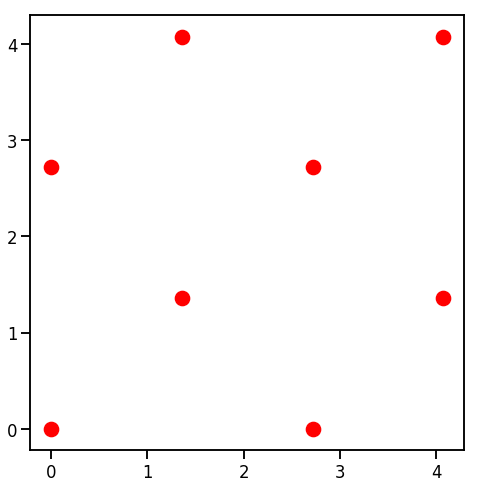

In [38]:
from ase.units import Bohr
p = calc.model.cell.ionic_positions.copy()
p = p[:, :, 0] # first species only
p = np.dot(calc.model.cell.real_lattice.T, p)
xi, yi, zi = p*Bohr
plt.scatter(xi, yi, s=200, c='r')
plt.axis([0, atoms.cell[0,0], 0, atoms.cell[1,1]]); plt.axis("scaled");

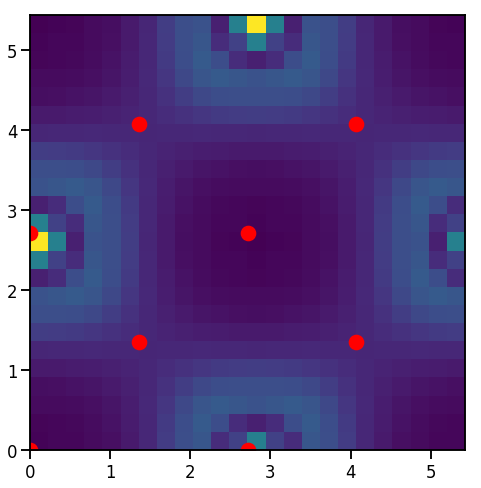

In [42]:
# overlay the charge density
plt.scatter(xi, yi, s=200, c='r')
den = calc.model.den.real_charge.copy()
basis = caspytep.basis.get_current_basis()
den3 = (den.reshape((basis.ngx, basis.ngy, 
                     basis.ngz), order='F') / 
        basis.total_grid_points)
plt.imshow(den3[:, :, basis.ngz//2],
           extent=[0, atoms.cell[0,0], 0, atoms.cell[1,1]]);

# Updating data inside a running Castep instance

- So far this is just analysis/post-processing, but could easily go beyond this and **steer calculations** based on results of e.g. Bader analysis.
- In the simplest case, we can move the ions and continue the calculation without having to restart from scratch (or do any I/O of `.check` files etc.).
- This allows embedded Castep to be **efficiently** used as a standard ASE calculator, with existing high-level algorithms: geometry optimisation, NEB, basin hopping, etc.
- Compared to file-based interface, save overhead of starting Castep each time
- Reuse electronic model from one ionic step to the next
- Wavefunction and charge density extrapolation possible just as in MD

# Example 1 - geometry optimisation

In [43]:
from ase.build import bulk
from ase.optimize import LBFGS
from caspytep.calculator import CasPyTep

atoms = bulk("Si", cubic=True)
calc = CasPyTep(atoms=atoms)
atoms.set_calculator(calc)
atoms.rattle(0.01)
a0 = atoms.copy()
opt = LBFGS(atoms)
opt.run(fmax=0.1)
print(atoms.get_potential_energy())

       Step     Time          Energy         fmax
LBFGS:    0 14:47:26    -1351.292128        0.3984
LBFGS:    1 14:47:29    -1351.299008        0.2784
LBFGS:    2 14:47:31    -1351.306229        0.0425
-1351.306229413231


# Example 2 - testing new algorithms

Python interface makes it quick to try out new high-level algorithms or connect things in new ways, e.g. testing a new preconditioned geometry optimizer [[Packwood2016](http://aip.scitation.org/doi/full/10.1063/1.4947024)]

In [44]:
from ase.optimize.precon import PreconLBFGS
from caspytep.calculator import CasPyTep

atoms = a0.copy() # restart from same randomised positions as above
atoms.set_calculator(CasPyTep(atoms=atoms))
opt = PreconLBFGS(atoms, precon='Exp')
opt.run(fmax=0.05)

PreconLBFGS:   0  14:47:59    -1351.292128       0.3984
estimate_mu(): mu=2.4754248008892463, mu_c=1.0
PreconLBFGS:   1  14:48:06    -1351.306085       0.0593
PreconLBFGS:   2  14:48:08    -1351.306387       0.0182


True

# Example 3 -  convergence testing

This is an example of using the native CasPyTep interface directly rather than the ASE compatibility layer. We increase the plane wave cutoff energy in steps of 10% until energy changes by less than $10^{-3}$ Hartree. (This isn't necessarily the best way to do convergence testing...)

In [46]:
from ase.build import bulk
from caspytep.calculator import CasPyTep

calc = CasPyTep(atoms=bulk("Si")) # 2-atom Si system

energy_tol = 1e-4
current_params = caspytep.parameters.get_current_params()
current_params.cut_off_energy = 7.0

cutoffs = []
energy = []

In [47]:
while True:
    caspytep.basis.basis_initialise(current_params.cut_off_energy)
    current_params.fine_gmax = (current_params.fine_grid_scale *
                                np.sqrt(2.0*current_params.cut_off_energy))
    caspytep.ion.ion_real_initialise()
    model = caspytep.model.model_state()
    model.converged = caspytep.electronic.electronic_minimisation(model)
    current_params.cut_off_energy *= 1.1    
    print('cutoff %.2f energy %.5f' % (current_params.cut_off_energy, 
                                       model.total_energy))
    cutoffs.append(current_params.cut_off_energy)
    energy.append(model.total_energy)    
    if len(energy) > 2 and abs(energy[-1] - energy[-2]) < energy_tol:
        print('converged at cutoff', cutoffs[-1])
        break

cutoff 7.70 energy -12.42124
cutoff 8.47 energy -12.42233
cutoff 9.32 energy -12.42250
cutoff 10.25 energy -12.42281
cutoff 11.27 energy -12.42289
converged at cutoff 11.273570000000007


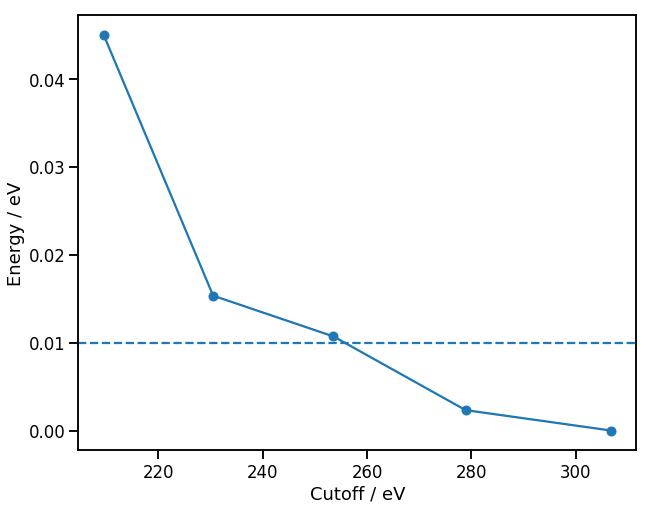

In [48]:
from ase.units import Hartree
ecut = np.array(cutoffs)*Hartree
ediff = np.array(energy)*Hartree
ediff -= ediff[-1]
plt.plot(ecut, abs(ediff), 'o-')
plt.xlabel('Cutoff / eV')
plt.ylabel('Energy / eV')
plt.axhline(0.01, linestyle='--');

# Missing features

- Make more example scripts and notebooks, e.g.:
    - MD with wavefunction extrapolation
    - Introspection and visualisation of wavefunctions/densities *in situ*
    - Integrate with your favourite post-processing/analysis tools - e.g. *OptaPyDOS*
- Improve Castep re-entrancy to allow multiple models/cells (partially done?)
    - e.g. allow `current_cell` to be updated in place without having to call `cell_read()`:
    should separate `cell_read()` into `cell_read()` and `cell_initialise()`
- Think more about what to reset when configuration changes...
    - e.g. symmetry operations may need to be updated when ions move
- Experiment with MPI parallelisation and benchmark wrt standard Castep
    - `mpirun -np N python script.py` works if CasPyTep compiled with MPI libraries    

# Over to you...

Download the image and have a play with CasPyTep in the practical session.

Install [Docker CE](https://www.docker.com/community-edition#/download) (free download) on your Linux/Mac/Windows machine (root access required), then:

    gzcat caspytep.tar.gz | docker load
    docker run -v ~:/root/host -p 8899:8899 caspytep
    
Then point your web brower at http://localhost:8899 and browse to **noteboooks > demo.ipynb** to open this notebook.

To open a `bash` shell instead:

    docker run -v ~:/root/host -it caspytep /bin/bash
    $ python
    >>> import caspytep

#  Summary - Benefits of Scripting Interfaces

**Primary:**
 - Automated preparation of input files
 - Analysis and post-processing
 - Batch processing
 
**Secondary:**
 - Expand access to advanced feautures to less experienced programmers
 - Simplify top-level programs
 - Unit and regression testing framework
 
**Longer term benefits:**
 - Encourages good software engineering in main code - modularity, well defined APIs
 - Speed up development of new algorithms by using an appropriate mixture of high- and low-level languages


# Conclusions and Outlook

- Scripting interfaces can be very useful for automating calculations, or connecting components in new ways
- Can give legacy C/Fortran code a new lease of life
- Provides interactive environment for testing, debugging, development and visualisation
- Appropriate mix of high- and low-level languages maximses overall efficiency